In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_100_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe'
]
linkage = 'ward'
metric = 'euclidean'

In [3]:
def preprocess_data(data):
    component_data = data.drop(columns=['percentile_25', 'percentile_75', 'median', 'std'], level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = StandardScaler().fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data)

    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    region_hulls = gpd.read_parquet(
            regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    )
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id)
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):

    ### primary chars
    region_hulls = gpd.read_parquet(
            regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    )
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
# )
# region_hulls.explore()

In [5]:
### generate and save linkage matricies for each region

# %%time
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id)
#     linkage_matrix = get_morphotope_linkage(data)
#     np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

### Setup regional cutoff to merge regional morphotopes

In [60]:
regional_cutoff = 15

In [61]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [62]:
%%time
morphotopes_data = read_morphotopes_data(model_params)

CPU times: user 19.7 s, sys: 5.98 s, total: 25.7 s
Wall time: 11.4 s


In [63]:
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
regional_ward_morphotopes_data = morphotopes_data.groupby(regional_clusters).mean()
regional_ward_morphotopes_data = regional_ward_morphotopes_data.iloc[:, :-1]
regional_ward_morphotopes_data

sdbAre                                                     \
         percentile_25      median percentile_75          std        mean   
10019_1      34.536730  114.068308    278.934558   650.286045  282.583524   
10019_10     29.591414   77.321654    147.444861   163.791489  118.394178   
10019_11     18.847849   36.570236     92.169744    49.536524   57.364671   
10019_12     28.424606   61.517916    111.470829    74.553089   80.058668   
10019_13     27.907766   61.151440    108.360001    78.276632   78.002345   
...                ...         ...           ...          ...         ...   
99886_52     61.498067  123.278905    185.278598   179.430589  156.523084   
99886_6      49.327802  141.792385    391.914222  1008.970477  379.480664   
99886_7      33.455443   84.415063    307.813081   924.528262  377.563642   
99886_8      68.056427  199.920394    415.662993   757.820836  432.521022   
99886_9      66.380578  206.079425    473.900208   533.507375  373.552123   

                sdbPer                                                 ...  \
         percentile_25     median percentile_75        std       mean  ...   
10019_1      25.312069  48.141677     77.322486  50.642453  60.643572  ...   
10019_10     23.559792  37.995651     52.087817  25.324299  41.711235  ...   
10019_11     19.071898  26.931763     41.016204  14.213961  30.502720  ...   
10019_12     23.275742  33.979346     46.376135  19.125748  36.903047  ...   
10019_13     22.848842  33.673006     45.144735  17.426332  35.850793  ...   
...                ...        ...           ...        ...        ...  ...   
99886_52     32.881491  47.836831     61.761740  31.255048  52.045140  ...   
99886_6      29.407011  51.412164     91.171801  64.928935  70.199947  ...   
99886_7      23.647200  39.388886     79.117487  68.012007  64.769012  ...   
99886_8      36.107616  63.178272     95.083265  74.579926  81.734931  ...   
99886_9      35.034095  63.246210    104.471824  59.434788  78.178399  ...   

                 mibFR                                              \
         percentile_25    median percentile_75       std      mean   
10019_1       2.598926  3.892183      5.491581  3.721435  4.680928   
10019_10      2.469697  2.901412      3.418221  1.276734  3.065962   
10019_11      2.440881  2.841616      3.200131  0.694075  2.823337   
10019_12      2.412081  2.787745      3.168981  0.698953  2.752917   
10019_13      2.283845  2.662463      3.062158  0.792215  2.674245   
...                ...       ...           ...       ...       ...   
99886_52      2.226469  2.883438      3.406777  1.110289  2.908672   
99886_6       2.051694  3.282357      4.950029  3.070233  3.932878   
99886_7       1.616690  2.722175      5.511442  3.905005  4.162024   
99886_8       3.430934  5.187315      7.172479  3.947179  6.131818   
99886_9       2.686715  4.399277      5.973036  2.779957  4.668703   

                mibSCo                                              
         percentile_25    median percentile_75       std      mean  
10019_1       2.598926  3.892183      5.491581  3.721435  4.680928  
10019_10      2.469697  2.901412      3.418221  1.276734  3.065962  
10019_11      2.440881  2.841616      3.200131  0.694075  2.823337  
10019_12      2.412081  2.787745      3.168981  0.698953  2.752917  
10019_13      2.283845  2.662463      3.062158  0.792215  2.674245  
...                ...       ...           ...       ...       ...  
99886_52      2.226469  2.883438      3.406777  1.110289  2.908672  
99886_6       2.051694  3.282357      4.950029  3.070233  3.932878  
99886_7       1.616690  2.722175      5.511442  3.905005  4.162024  
99886_8       3.430934  5.187315      7.172479  3.947179  6.131818  
99886_9       2.686715  4.399277      5.973036  2.779957  4.668703  

[22779 rows x 360 columns]

### Final ward clustering

In [7]:
# linkage_matrix = get_morphotope_linkage(preprocess_data(regional_ward_morphotopes_data))

In [6]:
region_id = 69333

# to_drop = [
#         'stcSAl','stbOri','stcOri','stbCeA',
#         'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
    
#     'sdbAre', 'ldsAre', 'sddAre', 'midAre', 'sdcAre', 'mdcAre', 'sdsAre', 'mibAre',

#     'sdbPer', 'ldsRea', 'mibLAL', 'ssbCCM', 'midRea' 
# ]

clip = None
to_drop = []

In [7]:
from core.utils import used_keys

In [30]:
cols = pd.Series(list(used_keys.keys()))
to_keep = ['mtbSWR', 'libNCo', 'mibERI', 'ssbERI', 'ssbElo',
           'mibElo', 'sdsSPW', 'sdbAre', 'sdbCoA', 'linP4W', 'linP3W', 'sdsLen']
to_drop = cols[~cols.isin(to_keep)].str.split('_').str[0].values
to_drop

array(['sdbPer', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbCCM', 'ssbCCD',
       'stbOri', 'ldbPWL', 'ltcBuA', 'mtbAli', 'mtbNDi', 'ltbIBD',
       'stbCeA', 'stbSAl', 'sssLin', 'ldsMSL', 'ldsRea', 'ldsAre',
       'sisBpM', 'sdsSPO', 'sdsSWD', 'mtdDeg', 'lcdMes', 'linPDE',
       'lcnClo', 'lddNDe', 'linWID', 'ldsCDL', 'xcnSCl', 'mtdMDi',
       'sddAre', 'midRea', 'midAre', 'stcOri', 'sdcLAL', 'sdcAre',
       'sscCCo', 'sscERI', 'mtcWNe', 'mdcAre', 'ltcWRB', 'sicCAR',
       'stcSAl', 'ldkAre', 'ldkPer', 'lskCCo', 'lskERI', 'lskCWA',
       'ltkOri', 'ltkWNB', 'likWBB', 'sdsAre', 'likWCe', 'mibCou',
       'mibAre', 'mibLen', 'mibCCo', 'mibLAL', 'mibFR', 'mibSCo'],
      dtype=object)

In [31]:
def preprocess_data(data):
    component_data = data.drop(columns=['percentile_25', 'percentile_75', 'median', 'std'], level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  ['_'.join(col).strip() for col in component_data.columns.values]
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = StandardScaler().fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data)
    return component_data

In [32]:
morphotopes_data = read_region_morphotope_data(region_id)
linkage_matrix = get_morphotope_linkage(morphotopes_data)

processing 69333


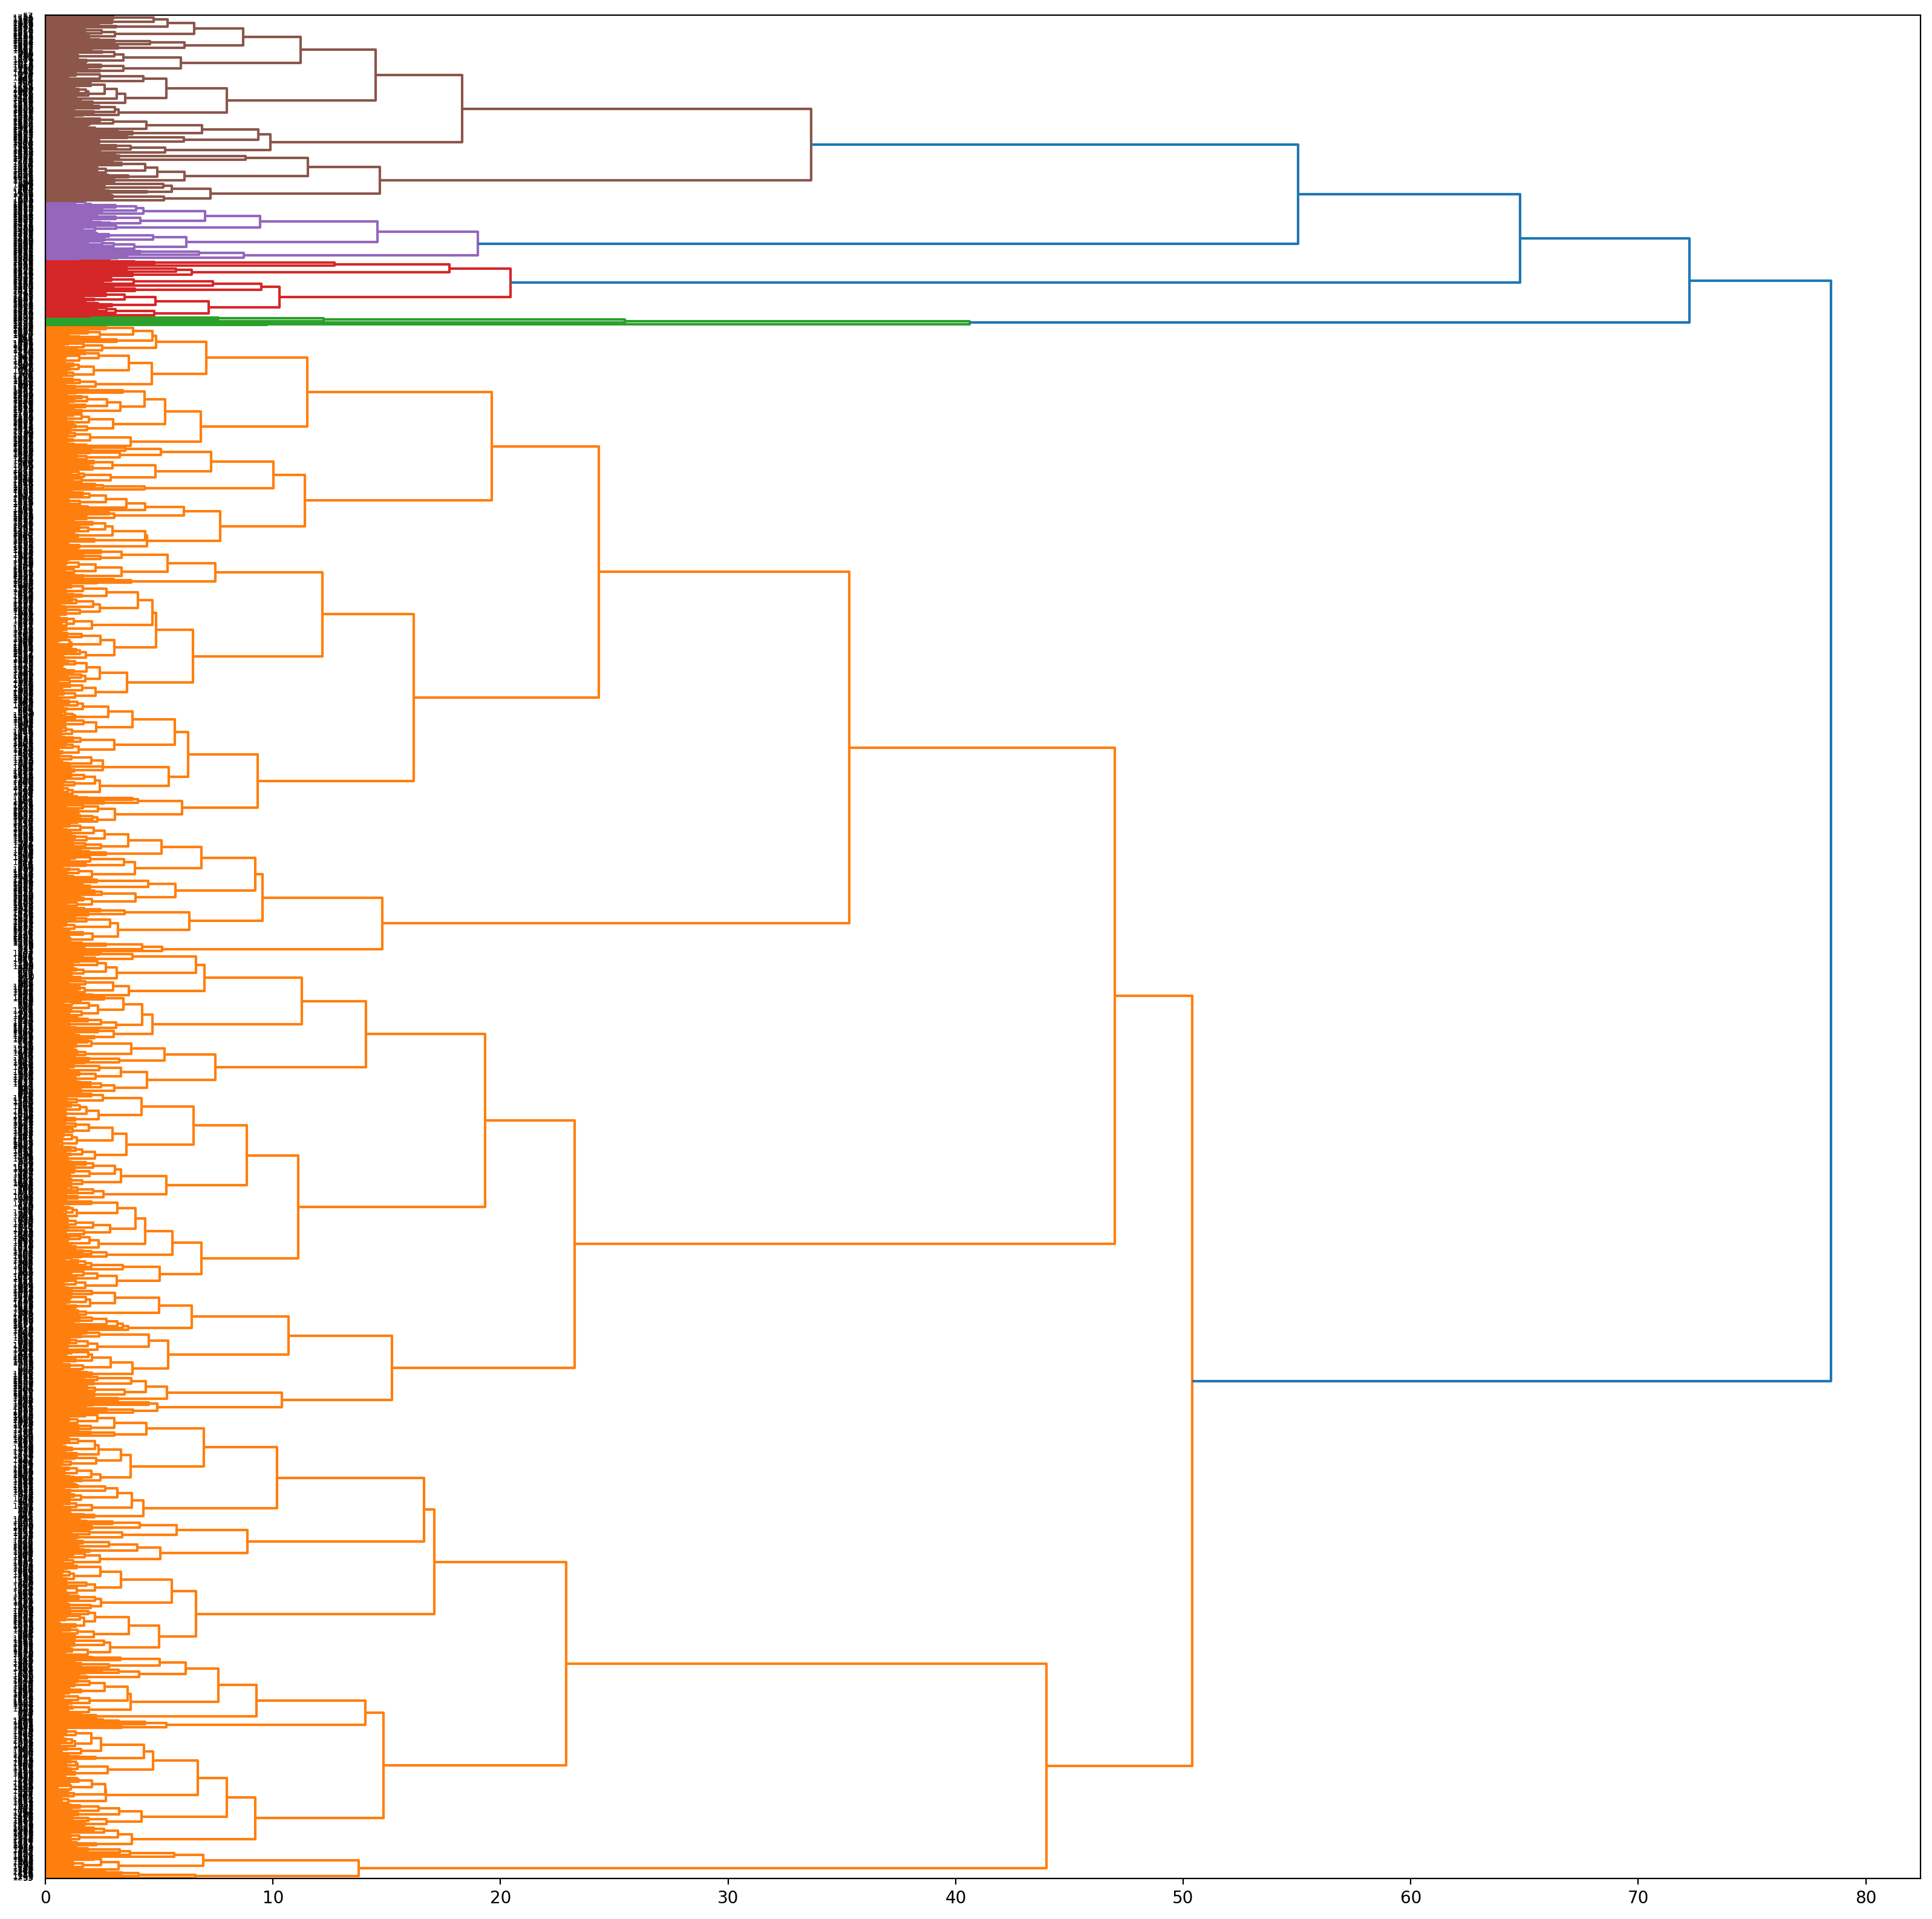

In [33]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix, ax=ax, orientation='right')

In [34]:
regional_cutoff = 20

In [35]:
clusters = fcluster(linkage_matrix, t=regional_cutoff, criterion='distance')
regional_clusters = pd.Series(clusters, morphotopes_data.index).astype(str)
regional_clusters = str(region_id) + '_' +regional_clusters

morphotopes_data = morphotopes_data.loc[regional_clusters.index]
regional_ward_morphotopes_data = morphotopes_data.groupby(regional_clusters).mean()
regional_ward_morphotopes_data = regional_ward_morphotopes_data.iloc[:, :-1]
regional_ward_morphotopes_data

,sdbAre_mean,sdbCoA_mean,ssbERI_mean,ssbElo_mean,mtbSWR_mean,libNCo_mean,sdsLen_mean,sdsSPW_mean,linP3W_mean,linP4W_mean,mibElo_mean
69333_1,-0.535797,-0.117841,0.749474,0.696599,-0.640100,-0.089293,5.729027,0.453345,-0.000202,-0.623205,0.872700
69333_10,2.042814,6.380593,-4.856163,-0.839544,2.317045,7.571275,-0.383865,-1.953402,0.623286,0.042826,-0.630611
69333_11,5.675184,23.462475,-8.616507,-1.723741,0.291367,0.827739,-0.324978,-0.386972,0.341539,0.867882,-0.791567
69333_12,3.528082,0.240421,-1.446794,-1.876209,-0.255497,-0.058622,-0.012092,2.286205,0.025749,0.070961,-1.078736
69333_13,6.416506,2.824136,-2.314319,-2.003382,-0.371471,-0.044713,0.282868,2.198981,0.063619,0.291804,-1.107917
69333_14,1.034743,0.447426,-0.674186,1.124574,2.229461,1.001310,-0.476617,-0.952144,-0.743155,1.828213,-0.468887
69333_15,-0.500278,-0.078568,1.625643,-1.999483,3.774493,-0.089293,-0.317609,-0.080988,0.481041,-0.042678,-3.160959
69333_16,-0.168479,-0.085293,0.525986,-0.067404,1.333697,-0.064391,-0.368434,-0.520935,0.312948,0.181290,-1.307890
69333_2,-0.378622,-0.105068,0.362901,0.652669,-0.531839,-0.088539,0.105048,1.166804,-0.318577,-0.092455,0.797963
69333_3,-0.411679,-0.114551,0.543945,0.616832,-0.547861,-0.089040,0.311310,0.201671,0.568191,-0.801156,0.780529


In [36]:
morphotopes_data.describe()

,sdbAre_mean,sdbCoA_mean,ssbERI_mean,ssbElo_mean,mtbSWR_mean,libNCo_mean,sdsLen_mean,sdsSPW_mean,linP3W_mean,linP4W_mean,mibElo_mean,mibERI_mean
count,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03,1.988000e+03
mean,-1.429663e-17,4.288990e-17,2.501911e-15,-1.358180e-15,1.000764e-16,2.144495e-17,-1.286697e-16,2.144495e-17,2.251720e-16,-1.000764e-16,-8.292048e-16,7.720183e-16
std,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00,1.000252e+00
min,-7.978545e-01,-1.178405e-01,-8.722845e+00,-5.221750e+00,-7.035829e-01,-8.929312e-02,-6.613440e-01,-4.062914e+00,-5.029501e+00,-1.448635e+00,-5.378046e+00,-7.321233e+00
25%,-3.776472e-01,-1.178405e-01,-4.163200e-01,-6.082137e-01,-5.917958e-01,-8.929312e-02,-4.335956e-01,-6.142200e-01,-6.078443e-01,-7.152532e-01,-5.006880e-01,-3.024640e-02
50%,-2.422477e-01,-1.178405e-01,9.510907e-02,1.793154e-01,-4.038614e-01,-8.929312e-02,-3.113524e-01,-7.919264e-02,7.901929e-02,-2.285810e-01,2.018659e-01,2.514648e-01
75%,-3.770854e-02,-1.178405e-01,5.624717e-01,7.267120e-01,1.294541e-01,-8.929312e-02,7.532629e-03,5.060622e-01,6.778196e-01,4.788070e-01,7.390184e-01,4.402445e-01
max,1.125467e+01,2.346247e+01,2.312693e+00,3.341331e+00,6.653864e+00,2.756812e+01,1.161761e+01,5.076226e+00,2.964309e+00,5.451677e+00,1.810111e+00,9.936936e-01


In [37]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=True)

In [38]:
## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else '-1')
etcs['regional'] = etcs['regional'].astype(str)

In [39]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(clusters), regional_clusters.values).drop_duplicates()
final_colors.loc['-1'] = [200, 200, 200]

layer.get_fill_color = final_colors.loc[etcs.regional].values.astype('uint8')

In [251]:
target_cluster = 13

In [265]:
# etcs[etcs.regional == str(region_id) + '_' + str(target_cluster)].explore(prefer_canvas=True, tiles='Cartodb positron')

In [156]:
from core.cluster_validation import get_feature_importance

In [157]:
regional_ward_morphotopes_data.shape

(155, 45)

In [158]:
imps = get_feature_importance(morphotopes_data, regional_clusters)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 co

In [159]:
imps = imps.iloc[:20]

imps = imps.loc[:, ~imps.columns.str.contains('_vals')]
np.unique(imps.values).shape

(46,)

In [160]:
pd.Series(imps.values.flatten()).value_counts()

mtdMDi_mean    96
sisBpM_mean    90
mibLen_mean    88
ldbPWL_mean    88
sdsSPW_mean    88
lcdMes_mean    87
ltcWRB_mean    86
ssbERI_mean    85
linPDE_mean    85
linWID_mean    84
ssbCor_mean    84
ldsMSL_mean    81
ltcBuA_mean    81
mibFR_mean     79
lcnClo_mean    78
ssbElo_mean    77
sicCAR_mean    77
mtbNDi_mean    76
mtbAli_mean    76
mtcWNe_mean    72
sdsSPO_mean    71
mtdDeg_mean    71
mibCou_mean    71
linP4W_mean    70
mibElo_mean    70
ssbCCo_mean    69
sdsSWD_mean    67
sdcLAL_mean    66
ltbIBD_mean    64
ssbSqu_mean    63
sssLin_mean    63
mibSCo_mean    60
lddNDe_mean    58
linP3W_mean    57
sscCCo_mean    55
ssbCCD_mean    52
stbSAl_mean    52
mtbSWR_mean    51
sdsLen_mean    49
mibERI_mean    46
xcnSCl_mean    46
sscERI_mean    40
libNCo_mean    38
mibCCo_mean    36
ldsCDL_mean    33
sdbCoA_mean    24
Name: count, dtype: int64

In [18]:
%%time
import lonboard
from sidecar import Sidecar

# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.07)

sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 6.91 s, sys: 442 ms, total: 7.35 s
Wall time: 7.34 s


In [19]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(clusters), regional_clusters.values).drop_duplicates()
final_colors.loc['-1'] = [200, 200, 200]

layer.get_fill_color = final_colors.loc[etcs.regional].values.astype('uint8')

In [43]:
linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

In [44]:
final_cutoff = 30

In [45]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

3    45
1    17
5     7
2     6
4     5
6     1
7     1
Name: count, dtype: int64

### Plotting

In [120]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [0, 0, 0]

In [47]:
# 107131 - krakow
# 86873 = vienna
# 69333 = prague
# munich
# 4 - rhineruhr
# 55763 - berlin
#bratislava - 99886
# freiburg - 5883
 # hamburg - 16242
# munich - 38679

In [49]:
region_id = 69333

In [50]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False)

In [51]:
## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)

In [52]:
# # can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [53]:
etcs = etcs.to_crs(epsg=4326)
etcs['geometry'] = etcs.geometry.make_valid()

In [54]:
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [55]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.35 s, sys: 159 ms, total: 1.51 s
Wall time: 1.51 s


In [56]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [57]:
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [188]:
# color by regional morphotope
layer.get_fill_color = get_color(etcs.label)

In [153]:
target_cluster = 96
etcs[etcs.final == target_cluster].shape

(2636, 9)

In [ ]:
# etcs[etcs.final == target_cluster].explore(prefer_canvas=True, tiles='Cartodb positron')

In [ ]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix,ax=ax)